In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from util import get_data, get_data2, plot_data, symbol_to_path
import datetime as dt
import matplotlib
from matplotlib import gridspec

matplotlib.rcParams.update({'font.size': 22})


# calculate and return normalized dataframe
def normalize(df):
    #result = pd.DataFrame({'Normalized Price': df / df.ix[0]})
    return df / df.ix[0]

# calculate and return standardized dataframe
def standardize(df):
    return (df-df.mean(axis=0))/df.std(axis=0)

# calculate and return dataframe of simple moving average
def SMA(df, window=2):
    SMA = pd.DataFrame({'SMA':df.rolling(window).mean()})
    return SMA


# calculate and return dataframe of Bollinger Bands
def BB(df, window=20):
    n = 2
    average = df.rolling(window).mean()
    std = df.rolling(window).std()
    upper = average + n * std
    lower = average - n * std
    percentage = (df-lower)/(upper-lower)
    result = pd.DataFrame({'BB_upper': upper, 'BB_lower': lower, 'BB_%': percentage})
    return result


# calculate and return dataframe of Moving Average Convergence Divergence
def MACD(df, n_fast=12, n_slow=26, n_macd=9):
    ema_slow = df.ewm(ignore_na=False, span=n_slow, min_periods=1, adjust=True).mean()
    ema_fast = df.ewm(ignore_na=False, span=n_fast, min_periods=1, adjust=True).mean()
    MACD = (ema_fast-ema_slow).ewm(ignore_na=False, span=n_macd, min_periods=1, adjust=True).mean()
    result = pd.DataFrame({'MACD': MACD})
    return result


# calculate and return dataframe of Relative Strength Index
def RSI(df, window):
    delta = df.diff()
    up = delta.copy()
    up[up < 0] = 0
    down = delta.copy()
    down[down > 0] = 0
    rolling_up = up.rolling(window).mean()
    rolling_down = down.rolling(window).mean()
    RS = rolling_up / rolling_down.abs()
    RSI = 100.0 - (100.0 / (1.0 + RS))
    result = pd.DataFrame({'RSI': RSI})
    return result


# calculate and return dataframe of On Balane Volume
def OBV(df_price, df_volume):
    OBV = df_price.copy()
    OBV[:] = 0
    delta = df_price.diff()
    for i in range(1, df_price.shape[0]):
        if delta[i] > 0:
            OBV.ix[i] = OBV.ix[i-1] + df_volume.ix[i, 1]
        elif delta[i] < 0:
            OBV.ix[i] = OBV.ix[i-1] - df_volume.ix[i, 1]
        elif delta[i] == 0:
            OBV.ix[i] = OBV.ix[i-1] + 0

    result = pd.DataFrame({'OBV': OBV},dtype=int)
    return result

def author():
    return 'zzhao38'

In [2]:
# in sample start and end dates
sd_train = dt.datetime(2008, 1, 1)
ed_train = dt.datetime(2009, 12, 31)

# out of sample start and end dates
sd_test = dt.datetime(2010, 1, 1)
ed_test = dt.datetime(2011, 12, 31)

# temporary start and end dates to get rid of NaN
sd_temp = dt.datetime(2007,11,1)
ed_temp = dt.datetime(2011,12,31)

dates_train = pd.date_range(sd_train, ed_train)
dates_test = pd.date_range(sd_test, ed_test)
dates_temp = pd.date_range(sd_temp,ed_temp)

symbols = ['AAPL']

# df_train = get_data2(symbols, dates_train)
# df_test = get_data2(symbols, dates_test)
df_temp = get_data2(symbols,dates_temp)

df_temp_price = df_temp.ix[:,0]
df_temp_volume = df_temp.ix[:,1]

df_temp_price =normalize(df_temp_price)

In [30]:
sma = normalize(SMA(df_temp_price, 20).ix[dates_train,:].dropna())
bb = BB(df_temp_price, 20).ix[dates_train,:].dropna()
bb_perc = standardize(BB(df_temp_price, 20)).ix[dates_train,:].dropna()
bb['BB_%'] = bb_perc['BB_%']
macd = standardize(MACD(df_temp_price)).ix[dates_train,:].dropna()
rsi = standardize(RSI(df_temp_price, 10)).ix[dates_train,:].dropna()
obv = standardize(OBV(df_temp_price, df_temp_volume)).ix[dates_train,:].dropna()
df_train_price_norm = normalize(df_temp_price.ix[dates_train].dropna())

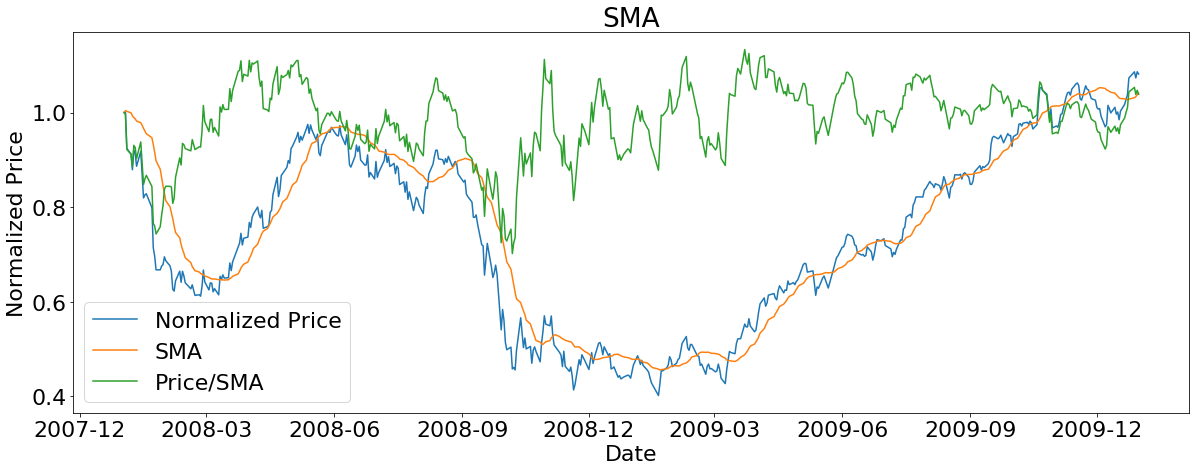

In [31]:
sma_plot = pd.concat([df_train_price_norm, sma, pd.DataFrame(df_train_price_norm)/sma.values], axis=1)
sma_plot.columns = ['Normalized Price', 'SMA', 'Price/SMA']

plt.figure(1, figsize=(20,7))
plt.plot(sma_plot)
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.title('SMA')
plt.legend(sma_plot.columns)
plt.show()

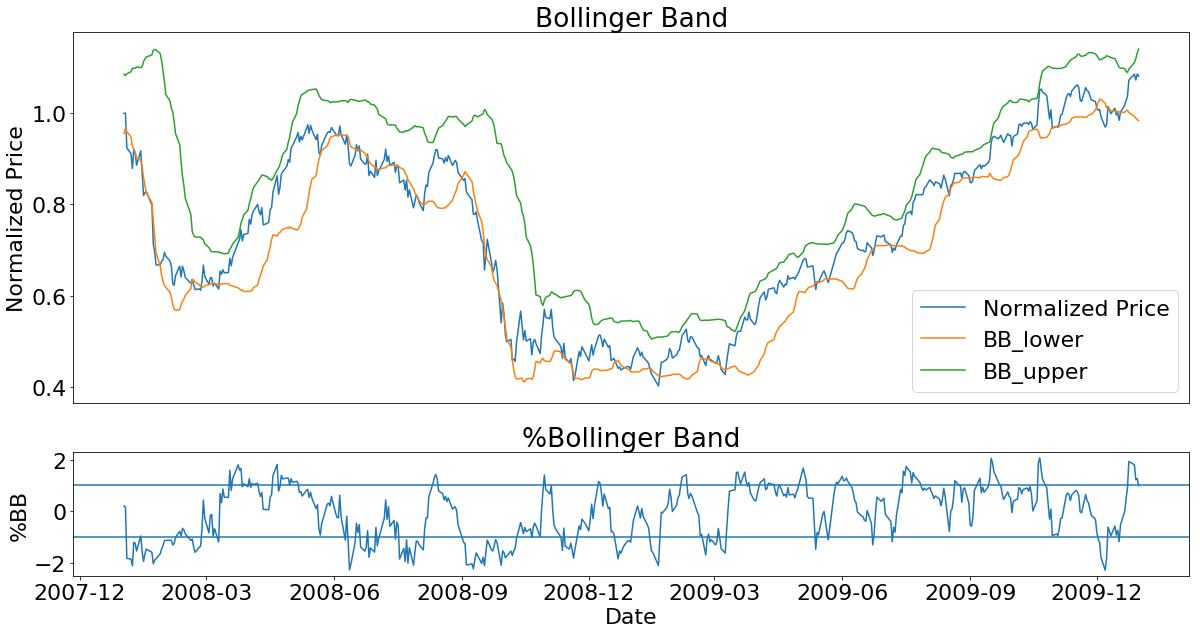

In [32]:
bb_plot = pd.concat([df_train_price_norm, bb], axis=1)
#bb_plot.columns = ['Normalized Price','BB_lower', 'BB_upper']

plt.figure(2, figsize=(20,10))
gs = gridspec.GridSpec(ncols=1,nrows=2, height_ratios=[3,1]) 
plt.subplot(gs[0])
plt.plot(bb_plot[['AAPL Adj Close','BB_lower', 'BB_upper']])
plt.xticks([])
#plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.title('Bollinger Band')
plt.legend(['Normalized Price','BB_lower', 'BB_upper'])
plt.subplot(gs[1])
plt.plot(bb_plot['BB_%'])
plt.axhline(-1)
plt.axhline(1)
plt.xlabel('Date')
plt.ylabel('%BB')
plt.title('%Bollinger Band')
plt.show()

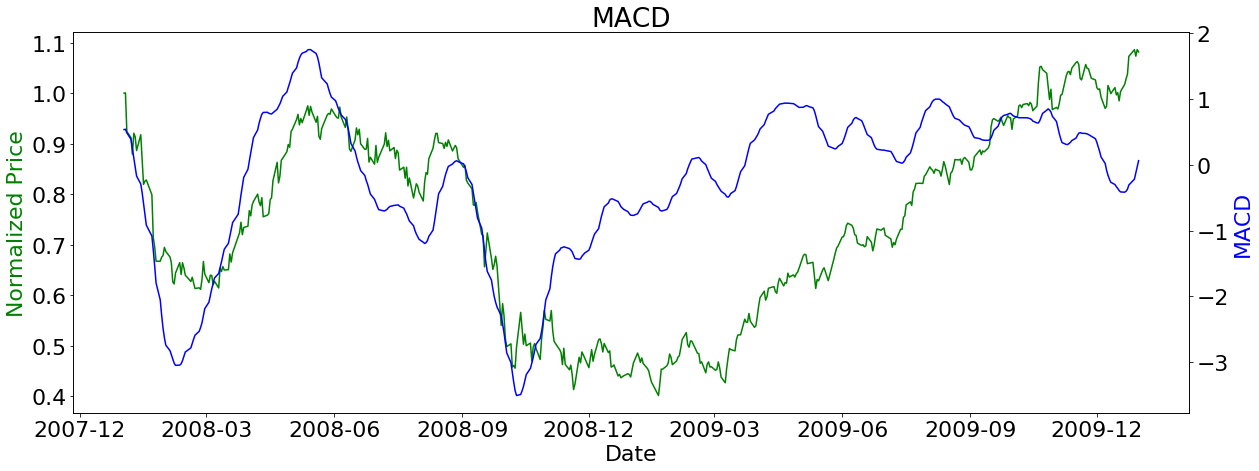

In [33]:
macd_plot = pd.concat([df_train_price_norm, macd], axis=1)

fig, ax1 = plt.subplots(figsize=(20,7))
ax2= ax1.twinx()
ax1.plot(df_train_price_norm, 'g-')
ax2.plot(macd, 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Price', color='g')
ax2.set_ylabel('MACD', color='b')
plt.title('MACD')
plt.show()

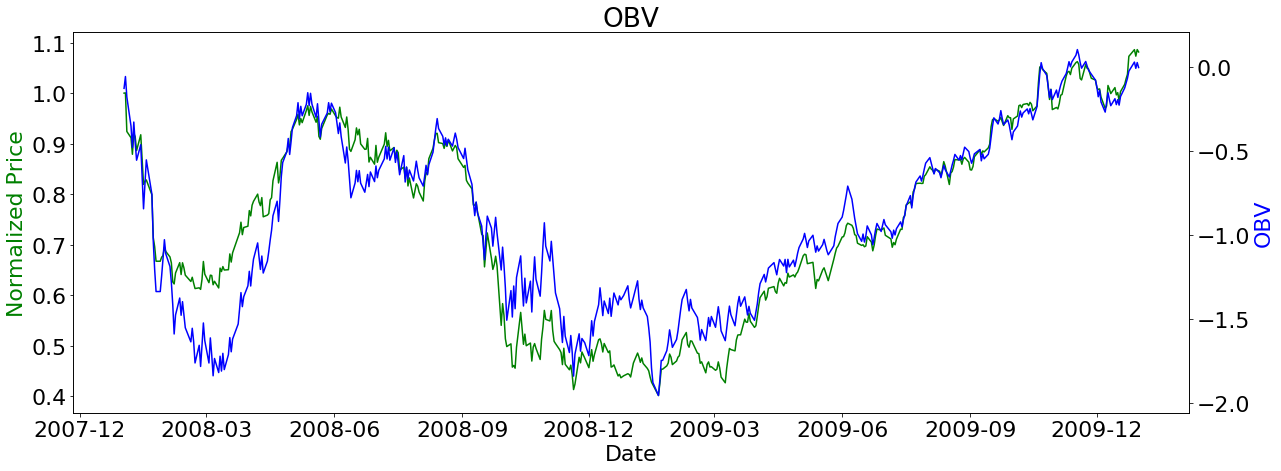

In [34]:
obv_plot = pd.concat([df_train_price_norm, obv], axis=1)

fig, ax1 = plt.subplots(figsize=(20,7))
ax2= ax1.twinx()
ax1.plot(df_train_price_norm, 'g-')
ax2.plot(obv, 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Price', color='g')
ax2.set_ylabel('OBV', color='b')
plt.title('OBV')
plt.show()

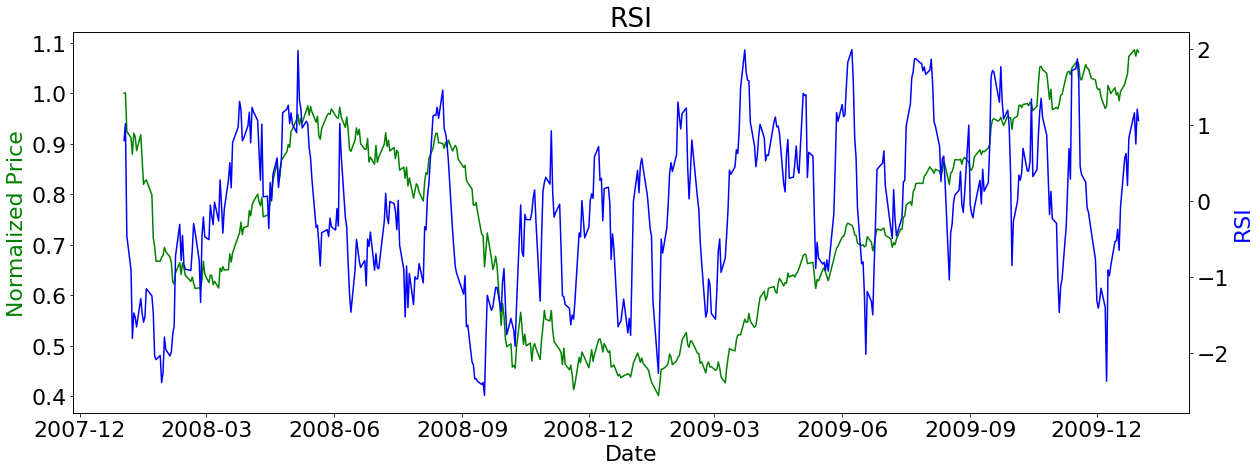

In [35]:
rsi_plot = pd.concat([df_train_price_norm, rsi], axis=1)
#bb_plot.columns = ['Price', 'Upper Bollinger Band', 'Lower Bollinger Band']

fig, ax1 = plt.subplots(figsize=(20,7))
ax2= ax1.twinx()
ax1.plot(df_train_price_norm, 'g-')
ax2.plot(rsi, 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Price', color='g')
ax2.set_ylabel('RSI', color='b')
plt.title('RSI')
plt.show()